# Imagenet Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDD
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* "first" preprocessing step of listing the files was removed (check `imagenet_demo.py`) because it did not affect performance in our tests. This should be reintroduced when simulating distributed training, e.g., federated learning, where getting the file locations can actually affect performance

* Dataset size: `146.899991342 GB` (`imagenet/ILSVRC/Data/CLS-LOC/train> du -hb .` / 1000 / 1000)
* Amount of `.JPEG` files: `1281167` (`imagenet/ILSVRC/Data/CLS-LOC/train> find . -name "*.JPEG" | wc -l`)
* Avg. filesize: `0.11466107957978935 MB`
* Avg. resolution (Imagenet paper): `400x350`
* Sample sizes (rounded to second decimal):
    * `   0500:        57.33 MB` 
    * `   1000:       114.66 MB`
    * `   2000:       229.32 MB`
    * `   4000:       458.64 MB`
    * `   8000:       917.29 MB`
    * `1281167: 146899.99 MB` 

In [1]:
full_dataset_samplecount = 1281167
for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_samplecount * 100, 2)}%")

500 of total: 0.04%
1000 of total: 0.08%
2000 of total: 0.16%
4000 of total: 0.31%
8000 of total: 0.62%


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')

from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [4]:
local_fig_dir = "imagenet-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../logs/final-logs/imagenet/16-threads"
path_to_cum_df = f"{home_path}/imagenet-storage-ceph-hdd_2021-10-13-14:55:35_cum-df_samples-1281167_threads-16-5-runs.csv"
path_to_cum_dstat_df = f"{home_path}/imagenet-storage-ceph-hdd_2021-10-13-14:55:35_cum-dstat-df_samples-1281167_threads-16-5-runs.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
# need to sort the strategies for some reason as they are not ascending
cum_df = cum_df.sort_values(by='split_name')
strategies   = list(cum_df.split_name.unique())
strategies_renamed = ["unprocessed", "concatinated", "decoded", "resized", "pixel-\ncentered"]

In [5]:
cum_df.head(5)

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,compression_type,storage_type
0,0.0,16,16,0.0,1281167,9408.493164,136.171326,0,1,495433,0-fully-online,2021-10-13-14:55:35,none,ceph-hdd
20,0.0,16,16,0.0,1281167,7554.033691,169.600372,0,1,b8f5b8,0-fully-online,2021-10-15-19:39:21,none,ceph-hdd
5,0.0,16,16,0.0,1281167,7349.570312,174.318619,0,1,2460a0,0-fully-online,2021-10-14-05:41:51,none,ceph-hdd
15,0.0,16,16,0.0,1281167,6805.959473,188.241943,0,1,2f160b,0-fully-online,2021-10-15-07:24:23,none,ceph-hdd
10,0.0,16,16,0.0,1281167,9640.943359,132.888138,0,1,0a63de,0-fully-online,2021-10-14-18:02:32,none,ceph-hdd


In [6]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,...,vm_allocated_mb,vm_free_mb,filesystem_files,filesystem_inodes,filelocks_posix,filelocks_lock,filelocks_read,filelocks_write,compression_type,storage_type
0,0.0,0.139219,4.049219,0.000000,0.000000,0,1281167,16,16,495433,...,0.01,0.01,1440.0,14186.0,3.0,2.0,0.0,5.0,none,ceph-hdd
1,1.0,11.972608,0.598016,0.000754,0.003920,0,1281167,16,16,495433,...,0.04,0.01,1440.0,14200.0,3.0,2.0,0.0,5.0,none,ceph-hdd
2,2.0,0.258048,0.000000,0.047273,0.033457,0,1281167,16,16,495433,...,0.06,0.00,1440.0,14251.0,3.0,2.0,0.0,5.0,none,ceph-hdd
3,3.0,4.128768,0.000000,13.358572,0.235990,0,1281167,16,16,495433,...,0.02,0.01,1440.0,14509.0,3.0,2.0,0.0,5.0,none,ceph-hdd
4,4.0,0.000000,0.000000,7.955322,0.171315,0,1281167,16,16,495433,...,0.01,0.00,1440.0,14714.0,3.0,2.0,0.0,5.0,none,ceph-hdd


## 0. Experiment Information

### 0.1 Experiment Count
We define an experiment as profiling a materialization strategy (e.g., `0-fully-online`) with a certain sample count (e.g., `500`).

We replicated **every** experiment **5** times, that means we should have `5 * <mat-strategies> * <thread_count>` experiments for each sample size. The only exception is the full dataset preprocessing, which is ran with `thread_count = 8`

Unfortunately the `ueid`s are based on the way the experiments were ran (in the python loop vs. bash loop), so we only count the rows, as each row in the `cum_df` dataframe is a single experiment.

In [7]:
experiment_count_dict = {
    "sample_count": []
  , "sample_experiment_count": []
  , "thread_count": []
  , "thread_experiment_count": []
  , "norm_thread_experiment_count": []
  , "runs_count": []
  , "runs_experiment_count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(sample_count, sample_experiment_count
              , thread_count, thread_experiment_count, norm_thread_experiment_count
              , runs_count, runs_experiment_count):
    '''Short helper'''
    experiment_count_dict["sample_count"] += [sample_count]
    experiment_count_dict["sample_experiment_count"] += [sample_experiment_count]
    experiment_count_dict["thread_count"] += [thread_count]
    experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]
    experiment_count_dict["norm_thread_experiment_count"] += [norm_thread_experiment_count]
    experiment_count_dict["runs_count"] += [runs_count]
    experiment_count_dict["runs_experiment_count"] += [runs_experiment_count]


for sample_count in cum_df["sample_count"].unique():
    sample_experiment_count = get_experiment_count(cum_df.query(f"sample_count=={sample_count}"))
    # for each thread setting
    for thread_count in cum_df.query(f"sample_count=={sample_count}")['thread_count'].unique():
        thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
        norm_thread_experiment_count = thread_experiment_count / len(strategies)        
        # for each run (epoch)
        for runs_count in cum_df.query(f"sample_count=={sample_count} and thread_count=={thread_count}")['runs_count'].unique():
            runs_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count} and runs_count=={runs_count}'))
            add_to_dict(sample_count, sample_experiment_count,
                        thread_count, thread_experiment_count, norm_thread_experiment_count, runs_count, runs_experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,sample_count,sample_experiment_count,thread_count,thread_experiment_count,norm_thread_experiment_count,runs_count,runs_experiment_count
0,1281167,25,16,25,5.0,0,25


# 1. Throughput Tradeoffs
### Full dataset, 16 threads, epoch 0

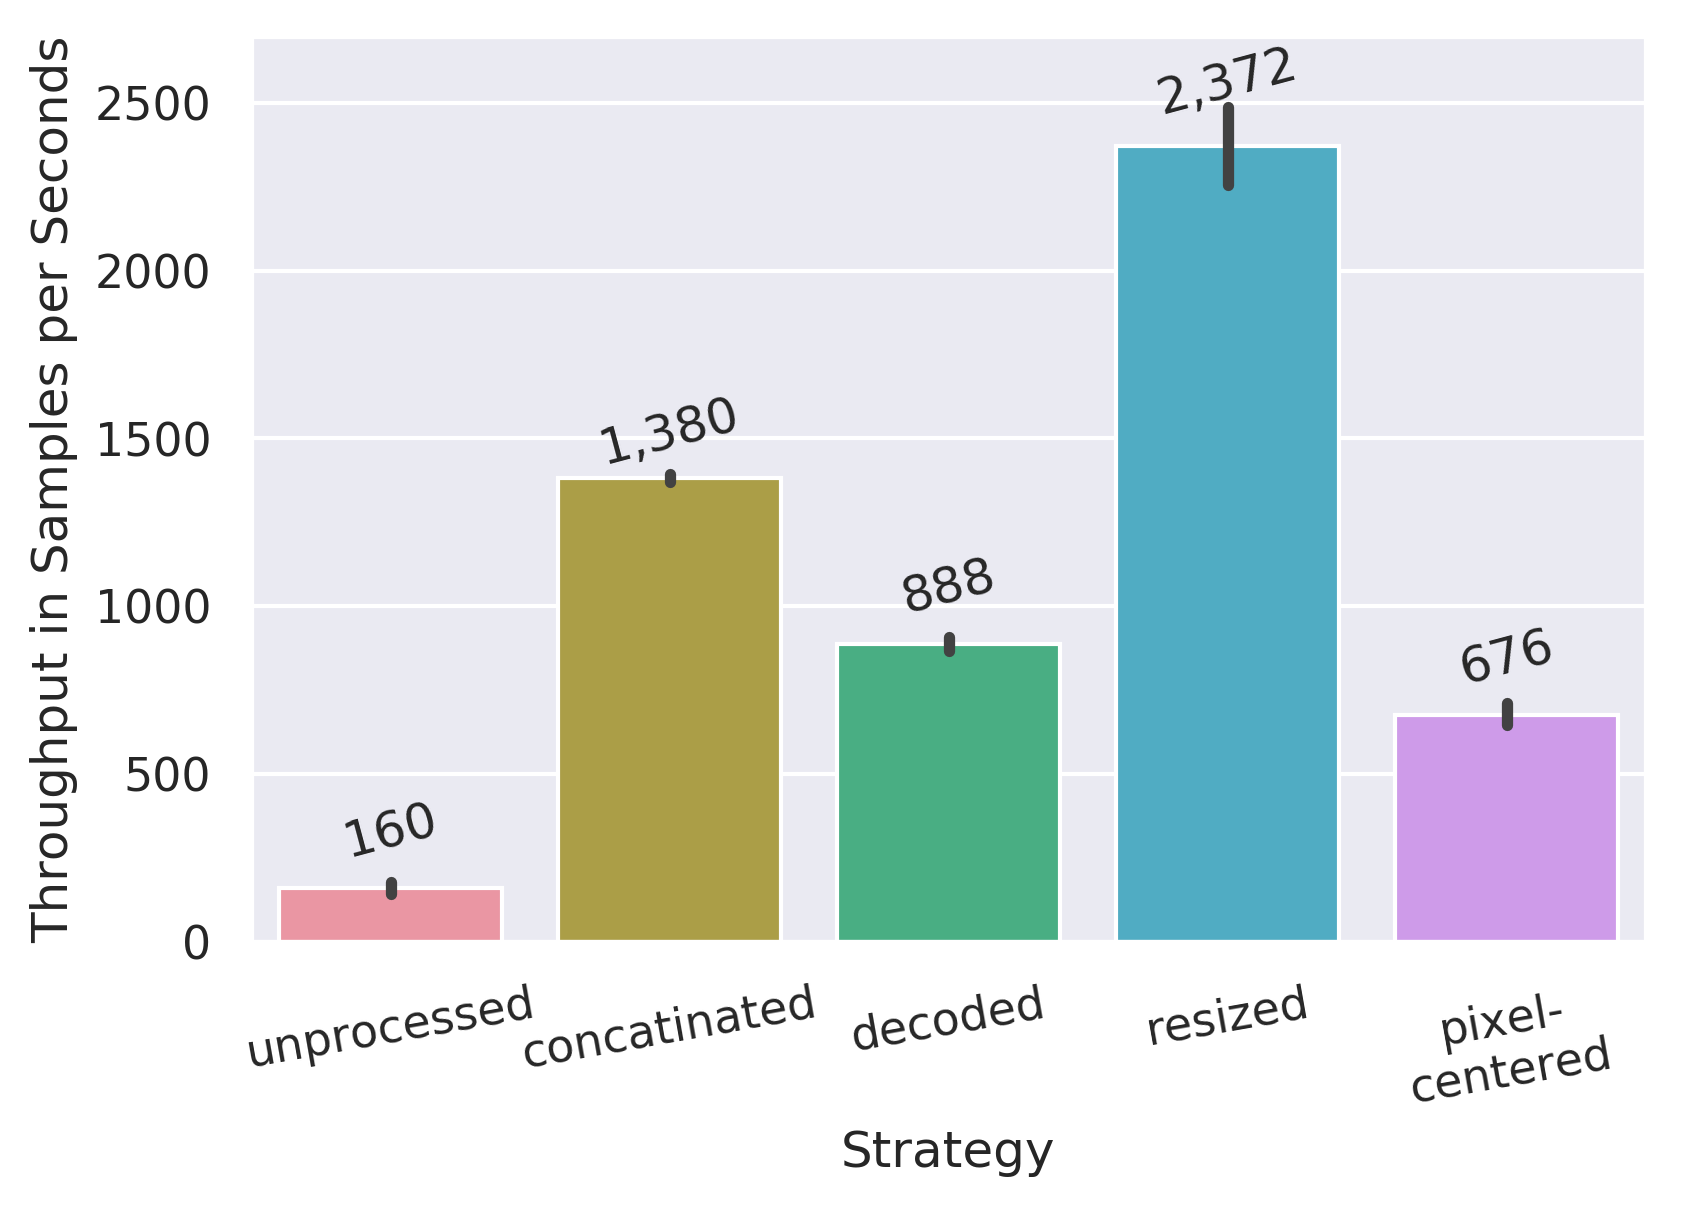

In [8]:
sns.set(palette=epoch_palette)

cum_df_temp = cum_df.query(f"sample_count=={full_dataset_samplecount} \
                         and thread_count==16")

plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
plot.set(ylim=(0, 2700))
#plot.legend(title="Epoch", ncol=1, labelspacing=0.1)
show_values_on_bars(plot, h_v="v", space=100, rotation=15, additional_space=[60, 50, 60, 100, 60
                                                                            ,0, 0, 0, 0, 0
                                                                            ,-50, -50, -50, -75, -50])

# 2. Network Readrate Analysis
### Full dataset, 16 threads, epoch 0

---------------------------------------
-- 0-fully-online Network Read in MB/s --
-- 0-fully-online Online Processing time: 8151
18.305587768554688
---------------------------------------
-- 2-read-image Network Read in MB/s --
-- 2-read-image Online Processing time: 928
156.1924285888672
---------------------------------------
-- 3-decode-image Network Read in MB/s --
-- 3-decode-image Online Processing time: 1443
554.840087890625
---------------------------------------
-- 4-resize-image Network Read in MB/s --
-- 4-resize-image Online Processing time: 541
673.15576171875
---------------------------------------
-- 5-center-pixel-values Network Read in MB/s --
-- 5-center-pixel-values Online Processing time: 1899
718.556884765625


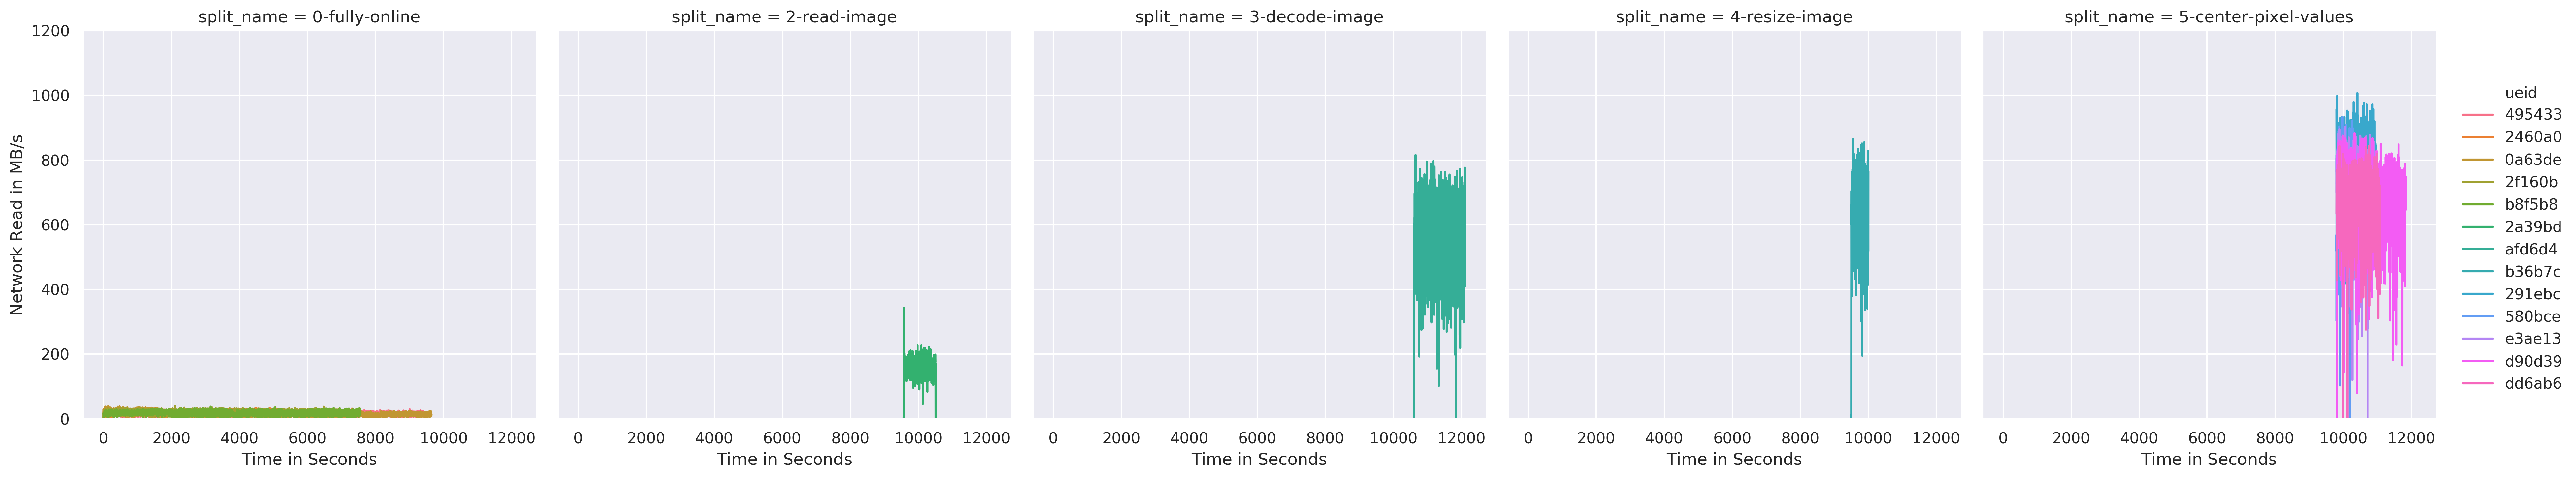

In [9]:
run = 0
threads = 16
sample_count = full_dataset_samplecount

def extract_online_processing_frames(split_name):
    '''
    '''    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df

split_names = cum_df.split_name.unique()
frames = [extract_online_processing_frames(split_name=split_name) for split_name in split_names]
online_df = pd.concat(frames)

for split_name in cum_df.split_name.unique():
    
    avg_online_processing_time = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
    print("---------------------------------------")
    print(f"-- {split_name} Network Read in MB/s --")
    print(f"-- {split_name} Online Processing time: {int(avg_online_processing_time)}")
    
    temp_df = online_df.query(f"split_name=='{split_name}'")
    print(temp_df.describe()["net_read_mbs"].iloc[1])
    
sns.set(palette=default_palette)

plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    col="split_name",
    kind="line",
    hue="ueid",
    data=online_df,
    #ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
plot.set(ylim=(0, 1200))

## Network speed comparison

In [19]:
net_speed_dict = {
    "threads": []
  , "split_name": []
  , "net_speed_mbs": []
}

def add_to_dict(threads, split_name, net_speed_mbs):
    net_speed_dict["threads"].append(threads)
    net_speed_dict["split_name"].append(split_name)
    net_speed_dict["net_speed_mbs"].append(net_speed_mbs)

add_to_dict(8, "0-fully-online", 12.287014961242676)
add_to_dict(8, "2-read-image", 111.27703094482422)
add_to_dict(8, "3-decode-image", 490.6575927734375)
add_to_dict(8, "4-resize-image", 469.9493408203125)
add_to_dict(8, "5-center-pixel-values", 585.87841796875)

add_to_dict(16, "0-fully-online", 16.961048126220703)
add_to_dict(16, "2-read-image", 156.1924285888672)
add_to_dict(16, "3-decode-image", 554.840087890625)
add_to_dict(16, "4-resize-image", 673.15576171875)
add_to_dict(16, "5-center-pixel-values", 760.87109375)

net_speed_df = pd.DataFrame(net_speed_dict)
net_speed_df

,threads,split_name,net_speed_mbs
0,8,0-fully-online,12.287015
1,8,2-read-image,111.277031
2,8,3-decode-image,490.657593
3,8,4-resize-image,469.949341
4,8,5-center-pixel-values,585.878418
5,16,0-fully-online,16.961048
6,16,2-read-image,156.192429
7,16,3-decode-image,554.840088
8,16,4-resize-image,673.155762
9,16,5-center-pixel-values,760.871094


```
>>> # decoded sps
... 
>>> 888 - 746
142
>>> # resized sps
... 
>>> 2372 - 1789
583
>>> # pixel-centered sps
... 
>>> 676 - 576
100
>> # decoded read speeds
>>> 555 - 491
64
>>> 

```

# 4. Number of Samples
## 500, 1000, 2000, 4000, 8000 samples + 8 threads + epoch 0

### Normalizing the processing time per samples and renaming the maximum sample count to "full"

In [7]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df["full_dataset_offline_processing_and_save_time_h"] = cum_df["full_dataset_offline_processing_and_save_time_m"] / 60


# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60
cum_df["full_dataset_processing_time_h"] = cum_df["full_dataset_processing_time_m"] / 60 


cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 1281167, 'sample_count'] = '1.3M (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '1.3M (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))

# 5. Speedup
## 8000 samples + 1, 2, 4, 8 threads + epoch 0
### Calculate the speedup 

In [9]:
unprocessed='0-fully-online'
resized='4-resize-image'
pixel_centered='5-center-pixel-values'
unprocessed_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==16 and split_name=='{unprocessed}'")["throughput_sps"].mean()
resized_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==16 and split_name=='{resized}'")["throughput_sps"].mean()
full_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==16 and split_name=='{pixel_centered}'")["throughput_sps"].mean()
print(f"Unprocessed    strategy throughput (16 threads):  {np.round(unprocessed_mean_throughput,0)} sps")
print(f"Resized        strategy throughput (16 threads): {np.round(resized_mean_throughput,0)} sps")
print(f"Pixel-centered strategy throughput (16 threads):  {np.round(full_mean_throughput,0)} sps")

Unprocessed    strategy throughput (16 threads):  148.0 sps
Resized        strategy throughput (16 threads): 2466.0 sps
Pixel-centered strategy throughput (16 threads):  703.0 sps


# X. Misc Plots and Calculations

## X.1 Calculation for the Introduction - unprocessed vs resized

In [15]:
unprocessed='0-fully-online'
resized='4-resize-image'
pixel_centered='5-center-pixel-values'
unprocessed_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==16 and split_name=='{unprocessed}'")["throughput_sps"].mean()
resized_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==16 and split_name=='{resized}'")["throughput_sps"].mean()
full_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==16 and split_name=='{pixel_centered}'")["throughput_sps"].mean()
print(f"Unprocessed    strategy throughput (8 threads):  {np.round(unprocessed_mean_throughput,0)} sps")
print(f"Resized        strategy throughput (8 threads): {np.round(resized_mean_throughput,0)} sps")
print(f"Pixel-centered strategy throughput (8 threads):  {np.round(full_mean_throughput,0)} sps")

Unprocessed    strategy throughput (8 threads):  121.0 sps
Resized        strategy throughput (8 threads): 1804.0 sps
Pixel-centered strategy throughput (8 threads):  577.0 sps


## X.2 Calculation for Analysis - Network Throughput for Unprocessed vs Concatinated

In [10]:
run = 0
threads = 16
sample_count = full_dataset_samplecount

def extract_online_processing_frames(split_name):
    '''
    '''    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df

split_names = cum_df.split_name.unique()
frames = [extract_online_processing_frames(split_name=split_name) for split_name in split_names]
online_df = pd.concat(frames)

for split_name in cum_df.split_name.unique():
    
    avg_online_processing_time = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
    print("---------------------------------------")
    print(f"-- {split_name} Network Read in MB/s --")
    print(f"-- {split_name} Online Processing time: {int(avg_online_processing_time)}")
    
    temp_df = online_df.query(f"split_name=='{split_name}'")
    print(temp_df.describe()["net_read_mbs"])

---------------------------------------
-- 0-fully-online Network Read in MB/s --
-- 0-fully-online Online Processing time: 8799
count    26400.000000
mean        16.961048
std          5.456847
min          0.000000
25%         13.586349
50%         16.844934
75%         20.361631
max         38.805264
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 2-read-image Network Read in MB/s --
-- 2-read-image Online Processing time: 922
count    944.000000
mean     156.192429
std       29.659544
min        0.000120
25%      144.102306
50%      156.758240
75%      171.731075
max      344.034851
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 3-decode-image Network Read in MB/s --
-- 3-decode-image Online Processing time: 1437
count    1523.000000
mean      554.840088
std       122.545586
min         0.000120
25%       495.530350
50%       572.280457
75%       633.112030
max       816.097656
Name: net_read_mbs, dtype: float64
---------

,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,61456.000000,61456.000000,61456.000000,61456.000000,61456.000000
mean,6115.019043,11.835742,1.124937,63.255825,23.778164
std,3728.200195,2.827317,0.406316,5.715010,3.948962
min,0.000000,0.000000,0.000000,35.242001,-10.861000
25%,2940.000000,9.975000,0.876000,59.449001,21.402000
50%,6012.500000,11.831000,1.126000,62.797001,23.899000
75%,9085.000000,13.819000,1.380000,66.456001,26.296000
max,15017.000000,24.090000,8.142000,106.741997,39.799999


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,3736.000000,3736.000000,3736.000000,3736.000000,3736.000000
mean,11035.107422,67.918060,2.976748,29.072939,0.016502
std,366.078064,6.020532,0.692407,5.830507,0.365117
min,10409.000000,0.000000,0.000000,16.730000,-3.275000
25%,10720.000000,65.601252,2.632000,25.664000,0.000000
50%,11031.000000,68.741997,2.911000,28.293500,0.000000
75%,11342.250000,71.248001,3.275000,31.572001,0.000000
max,11746.000000,80.376999,12.547000,96.490997,13.476000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,4708.000000,4708.000000,4708.000000,4708.000000,4708.000000
mean,13410.279297,43.435333,10.806701,43.974148,1.725290
std,404.672394,8.627759,2.060916,9.497391,1.428409
min,12798.000000,0.000000,0.000000,21.100000,-17.188999
25%,13078.750000,39.029999,9.637000,37.606251,0.881000
50%,13373.000000,44.395000,10.859000,42.839001,1.500000
75%,13667.000000,49.246499,12.171000,48.684499,2.351750
max,14450.000000,64.607002,19.497000,94.117996,22.528000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,741.000000,741.000000,741.000000,741.000000,741.000000
mean,15277.000000,49.856232,14.668409,34.565899,0.817688
std,214.052567,9.447732,2.110290,10.270963,1.226882
min,14907.000000,0.000000,5.000000,20.860001,-1.887000
25%,15092.000000,47.826000,13.699000,28.823999,0.127000
50%,15277.000000,52.146000,14.969000,32.035999,0.385000
75%,15462.000000,55.082001,16.010000,36.735001,1.134000
max,15647.000000,62.134998,25.344999,88.375000,16.250000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,4520.000000,4520.000000,4520.000000,4520.000000,4520.000000
mean,16740.697266,23.366339,14.907925,54.637680,7.016906
std,652.838562,6.231072,2.735295,8.212052,2.510004
min,15671.000000,0.000000,0.000000,31.830000,-6.076000
25%,16170.000000,19.471250,13.325000,49.367001,5.353750
50%,16735.000000,22.931999,15.197000,54.050999,6.863500
75%,17300.000000,27.321500,16.812250,59.344249,8.449000
max,17978.000000,45.026001,21.771999,99.750000,23.719999


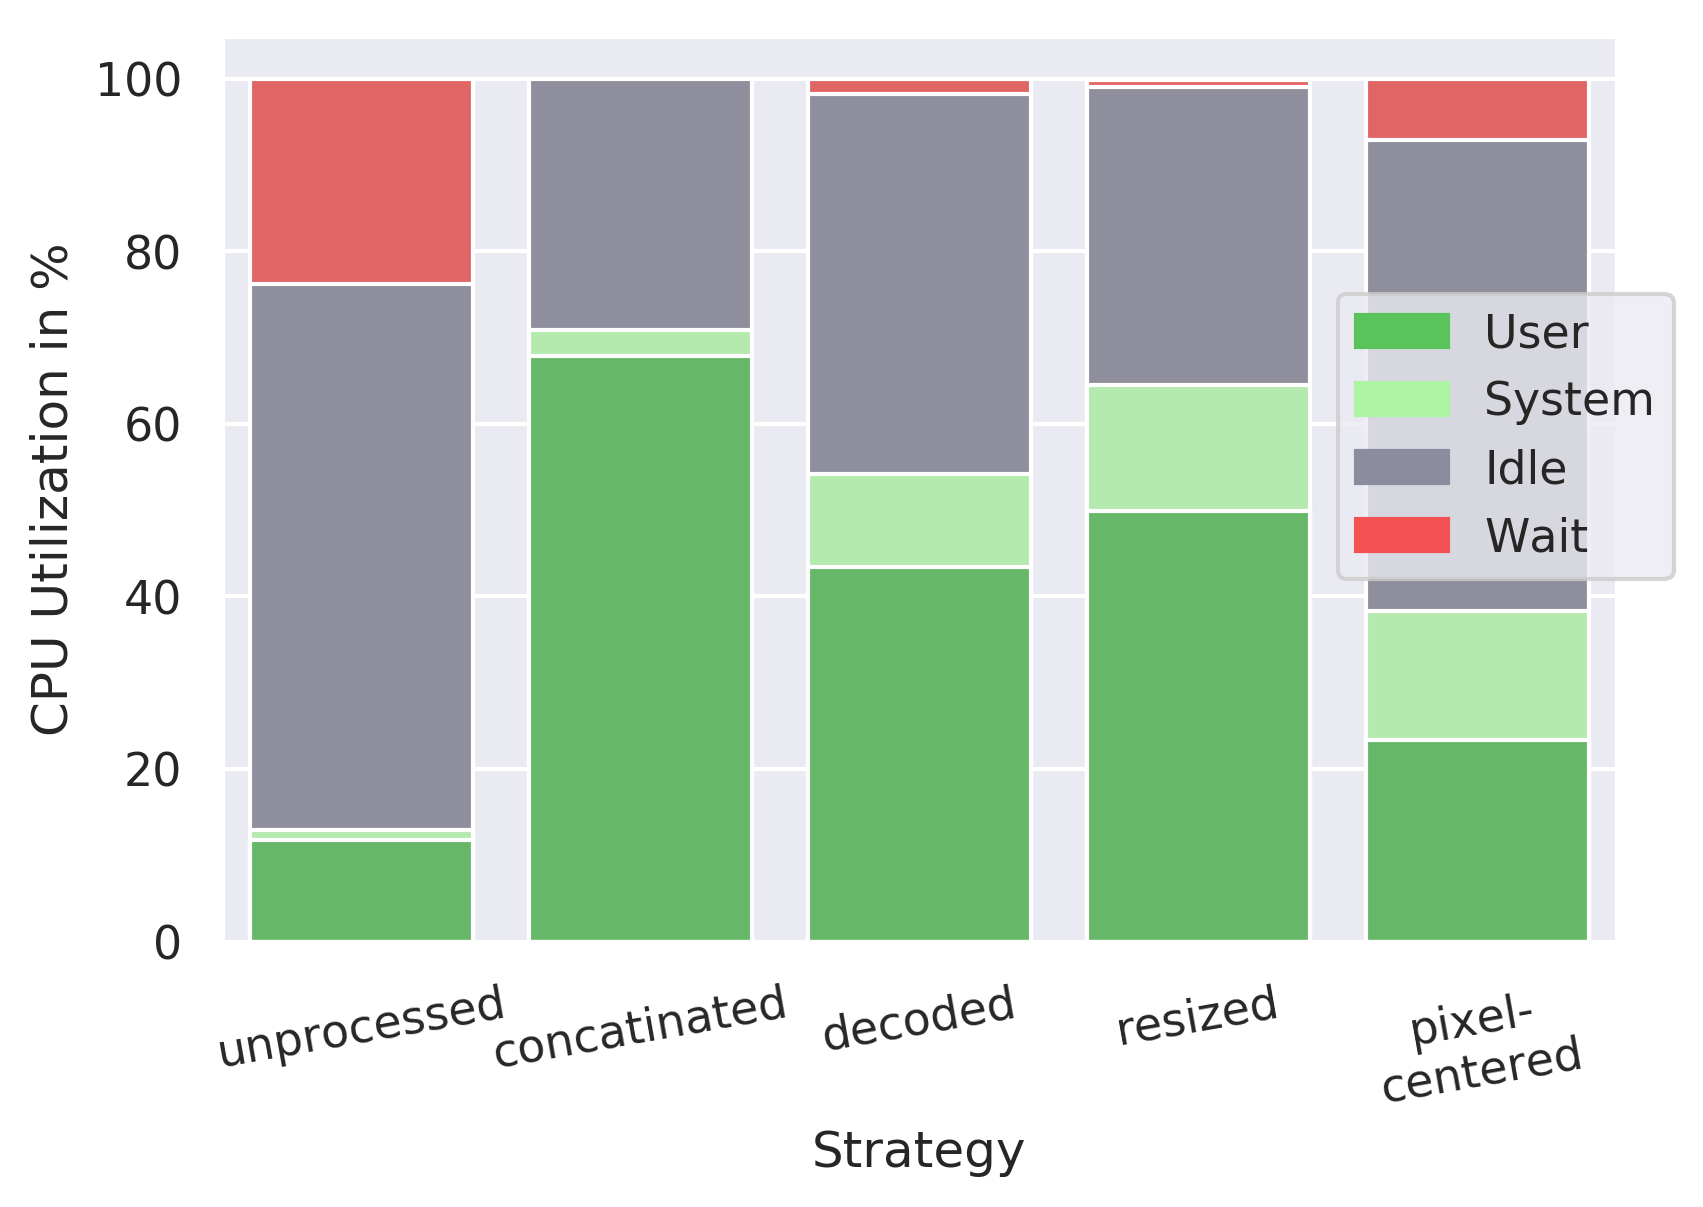

In [42]:
def extract_cpu_online_processing_time(split_name):
    '''
    '''
    run = 0
    threads = 8
    sample_count = full_dataset_samplecount
    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df[['rel_time_s','cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent','split_name']]

split_names = cum_df.split_name.unique()

frames = [extract_cpu_online_processing_time(split_name=split_name) for split_name in split_names]

online_cpu_df = pd.concat(frames)

def create_cumulative_and_aggregated_cpu_values(df):
    
    cpu_dict = {
        'split_name': []
      , 'cpu_usr_cum': []
      , 'cpu_sys_cum': []
      , 'cpu_idle_cum': []
      , 'cpu_wait_cum': []
    }
    
    def add_to_dict(split_name, usr, sys, idle, wait):
        cpu_dict['split_name'] += [split_name]
        cpu_dict['cpu_usr_cum'] += [usr]
        cpu_dict['cpu_sys_cum'] += [sys]
        cpu_dict['cpu_idle_cum'] += [idle]
        cpu_dict['cpu_wait_cum'] += [wait]
    
    for split_name in split_names:
        describe_df = df.query(f"split_name=='{split_name}'").describe()
        mean_df = describe_df.iloc[1] # get the mean
        mean_df['split_name'] = split_name
        mean_df['cpu_usr_sys_in_percent'] = mean_df['cpu_usr_in_percent'] \
                                          + mean_df['cpu_sys_in_percent']
        mean_df['cpu_usr_sys_idle_in_percent'] = mean_df['cpu_usr_sys_in_percent'] \
                                               + mean_df['cpu_idle_in_percent']
        mean_df['cpu_usr_sys_idle_wait_in_percent'] = mean_df['cpu_usr_sys_idle_in_percent'] \
                                                    + mean_df['cpu_wait_in_percent']

        mean_df['cpu_usr_cum'] = mean_df['cpu_usr_in_percent']
        mean_df['cpu_sys_cum'] = mean_df['cpu_usr_sys_in_percent']
        mean_df['cpu_idle_cum'] = mean_df['cpu_usr_sys_idle_in_percent']
        mean_df['cpu_wait_cum'] = mean_df['cpu_usr_sys_idle_wait_in_percent']
        add_to_dict(split_name=split_name, usr=mean_df['cpu_usr_cum']
                   ,sys=mean_df['cpu_sys_cum']
                   ,idle=mean_df['cpu_idle_cum']
                   ,wait=mean_df['cpu_wait_cum'])
        display(describe_df)

    return pd.DataFrame(cpu_dict)
    
cumulative_cpu_df = create_cumulative_and_aggregated_cpu_values(df=online_cpu_df)

green1 = "#5AC45C"
green2 = "#acf4a3"
grey = "#8c8c9f"
red = "#f45252"

bar4 = sns.barplot(x="split_name",  y="cpu_wait_cum", data=cumulative_cpu_df, color=red)
bar3 = sns.barplot(x="split_name",  y="cpu_idle_cum", data=cumulative_cpu_df, color=grey)
bar2 = sns.barplot(x="split_name",  y="cpu_sys_cum", data=cumulative_cpu_df, color=green2)
bar1 = sns.barplot(x="split_name",  y="cpu_usr_cum", data=cumulative_cpu_df, color=green1)
plot = bar1

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="CPU Utilization in %")

# add legend
legend_bar1 = mpatches.Patch(color=green1, label='User')
legend_bar2 = mpatches.Patch(color=green2, label='System')
legend_bar3 = mpatches.Patch(color=grey, label='Idle')
legend_bar4 = mpatches.Patch(color=red, label='Wait')
plt.legend(handles=[legend_bar1,legend_bar2,legend_bar3,legend_bar4], loc=(0.8,0.4))

,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,15018.000000,15018.000000,15018.000000,15018.000000,15018.000000
mean,7508.500000,9.744176,0.885977,62.961781,26.404024
std,4335.467285,1.842238,0.304964,5.146403,3.766878
min,0.000000,0.000000,0.000000,41.887001,0.004000
25%,3754.250000,8.657000,0.631000,59.497002,24.212000
50%,7508.500000,9.912000,0.878000,62.530998,26.600000
75%,11262.750000,11.028000,1.118500,65.829002,28.931000
max,15017.000000,16.855000,4.025000,99.956001,39.799999


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000
mean,11077.500000,67.384766,2.97191,29.586943,0.040688
std,386.391632,8.170869,0.93107,7.592018,0.585966
min,10409.000000,0.000000,0.00000,17.146000,-1.633000
25%,10743.250000,65.425499,2.62200,25.828000,0.000000
50%,11077.500000,68.647499,2.90000,28.454000,0.000000
75%,11411.750000,71.176003,3.25000,31.742500,0.000000
max,11746.000000,80.224998,12.54700,96.490997,13.476000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000
mean,11969.000977,42.960464,12.083580,43.198078,1.678643
std,509.078583,9.416759,2.252332,10.505068,1.670583
min,11088.000000,0.000000,0.000000,23.048000,-26.441000
25%,11528.500000,39.571501,11.083000,36.762001,0.874500
50%,11969.000000,44.640999,12.330000,41.301998,1.380000
75%,12409.500000,48.639999,13.452000,47.344999,2.144000
max,12850.000000,60.799000,25.063000,87.610001,12.516000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,695.000000,695.000000,695.000000,695.000000,695.000000
mean,11623.000000,53.388378,11.382115,34.503506,0.679709
std,200.773499,11.288633,1.837900,11.762455,1.245779
min,11276.000000,0.000000,2.239000,17.816999,-6.888000
25%,11449.500000,51.289000,10.660000,27.785000,0.124000
50%,11623.000000,55.799000,11.667000,32.138000,0.253000
75%,11796.500000,59.657000,12.492000,36.832500,1.010500
max,11970.000000,71.446999,17.610001,87.500000,10.263000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000
mean,16498.500000,22.721987,15.255469,54.573376,7.373434
std,723.564209,5.721790,2.596523,7.855466,2.599343
min,15246.000000,0.000000,0.876000,34.615002,-1.880000
25%,15872.250000,19.448000,13.802000,49.621249,5.653000
50%,16498.500000,22.528000,15.550000,53.773500,7.241000
75%,17124.750000,26.242001,17.026250,58.775249,8.906000
max,17751.000000,42.020000,32.020000,99.750000,23.719999


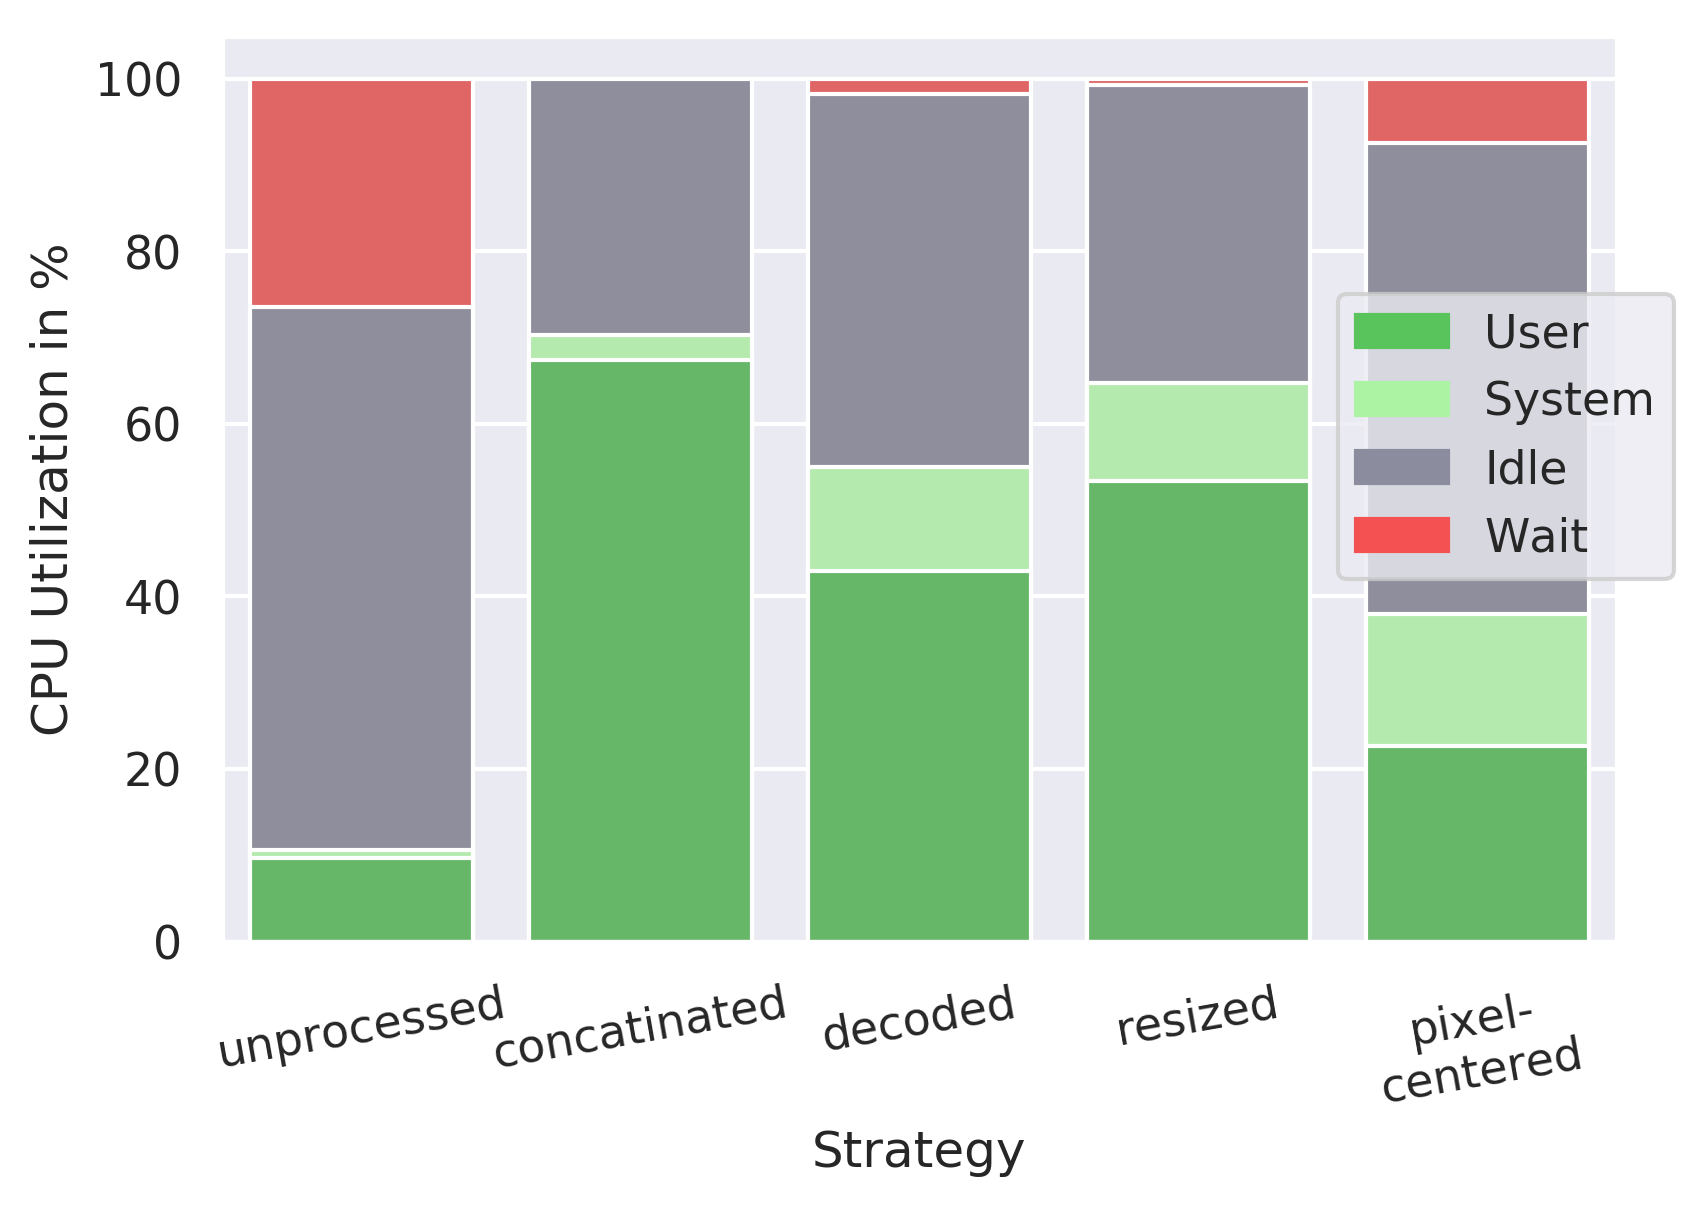

In [41]:
def extract_cpu_online_processing_time(split_name):
    '''
    '''
    run = 0
    threads = 8
    sample_count = full_dataset_samplecount


    experiment_df = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}").head(1)

    # picking one experiment
    ueid = experiment_df['ueid'].iloc[0]
    offline_processing_time_s = experiment_df["offline_processing_and_save_time_s"].iloc[0]

    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          ueid=='{ueid}' and \
          rel_time_s>={offline_processing_time_s}")
    
    return filtered_dstat_df[['rel_time_s','cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent','split_name']]
    

split_names = cum_df.split_name.unique()
frames = [extract_cpu_online_processing_time(split_name=split_name) for split_name in split_names]
online_cpu_df = pd.concat(frames)

def create_cumulative_and_aggregated_cpu_values(df):
    
    cpu_dict = {
        'split_name': []
      , 'cpu_usr_cum': []
      , 'cpu_sys_cum': []
      , 'cpu_idle_cum': []
      , 'cpu_wait_cum': []
    }
    
    def add_to_dict(split_name, usr, sys, idle, wait):
        cpu_dict['split_name'] += [split_name]
        cpu_dict['cpu_usr_cum'] += [usr]
        cpu_dict['cpu_sys_cum'] += [sys]
        cpu_dict['cpu_idle_cum'] += [idle]
        cpu_dict['cpu_wait_cum'] += [wait]
    
    for split_name in split_names:
        describe_df = df.query(f"split_name=='{split_name}'").describe()
        mean_df = describe_df.iloc[1] # get the mean
        mean_df['split_name'] = split_name
        mean_df['cpu_usr_sys_in_percent'] = mean_df['cpu_usr_in_percent'] \
                                          + mean_df['cpu_sys_in_percent']
        mean_df['cpu_usr_sys_idle_in_percent'] = mean_df['cpu_usr_sys_in_percent'] \
                                               + mean_df['cpu_idle_in_percent']
        mean_df['cpu_usr_sys_idle_wait_in_percent'] = mean_df['cpu_usr_sys_idle_in_percent'] \
                                                    + mean_df['cpu_wait_in_percent']

        mean_df['cpu_usr_cum'] = mean_df['cpu_usr_in_percent']
        mean_df['cpu_sys_cum'] = mean_df['cpu_usr_sys_in_percent']
        mean_df['cpu_idle_cum'] = mean_df['cpu_usr_sys_idle_in_percent']
        mean_df['cpu_wait_cum'] = mean_df['cpu_usr_sys_idle_wait_in_percent']
        add_to_dict(split_name=split_name, usr=mean_df['cpu_usr_cum']
                   ,sys=mean_df['cpu_sys_cum']
                   ,idle=mean_df['cpu_idle_cum']
                   ,wait=mean_df['cpu_wait_cum'])
        display(describe_df)

    return pd.DataFrame(cpu_dict)
    
cumulative_cpu_df = create_cumulative_and_aggregated_cpu_values(df=online_cpu_df)

green1 = "#5AC45C"
green2 = "#acf4a3"
grey = "#8c8c9f"
red = "#f45252"

bar4 = sns.barplot(x="split_name",  y="cpu_wait_cum", data=cumulative_cpu_df, color=red)
bar3 = sns.barplot(x="split_name",  y="cpu_idle_cum", data=cumulative_cpu_df, color=grey)
bar2 = sns.barplot(x="split_name",  y="cpu_sys_cum", data=cumulative_cpu_df, color=green2)
bar1 = sns.barplot(x="split_name",  y="cpu_usr_cum", data=cumulative_cpu_df, color=green1)
plot = bar1

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="CPU Utilization in %")

# add legend
legend_bar1 = mpatches.Patch(color=green1, label='User')
legend_bar2 = mpatches.Patch(color=green2, label='System')
legend_bar3 = mpatches.Patch(color=grey, label='Idle')
legend_bar4 = mpatches.Patch(color=red, label='Wait')
plt.legend(handles=[legend_bar1,legend_bar2,legend_bar3,legend_bar4], loc=(0.8,0.4))

## X.2 Warning - Creating the plots based on `dstat` logs can take several hours

In [11]:
cum_dstat_df_copy = cum_dstat_df.copy(deep=True)
cum_dstat_df_copy["sample_count"] = cum_dstat_df_copy.sample_count.astype('category')
cum_dstat_df_copy["split_name"] = cum_dstat_df_copy.split_name.astype('category')
cum_dstat_df_copy["run"] = cum_dstat_df_copy.run.astype('category')
cum_dstat_df_copy["thread_count"] = cum_dstat_df_copy.thread_count.astype('category')
strategy_list = list(cum_dstat_df_copy.split_name.unique())
strategy_list

['0-fully-online',
 '2-read-image',
 '3-decode-image',
 '4-resize-image',
 '5-center-pixel-values']

In [12]:
test_df = cum_df.query(f"sample_count=={full_dataset_samplecount} and \
               thread_count==16 and \
               split_name=='3-decode-image' and \
               runs_count==0")

display(test_df["per_sample_online_processing_time_s"].describe())
display(((test_df["shard_cum_size_MB"] / full_dataset_samplecount)).describe())

per_sample_time_s = test_df["per_sample_online_processing_time_s"].describe().iloc[1]
per_sample_size_mb = (test_df["shard_cum_size_MB"] / full_dataset_samplecount).describe().iloc[1]

per_sample_size_mb / per_sample_time_s

count    3.000000
mean     0.001122
std      0.000047
min      0.001081
25%      0.001096
50%      0.001111
75%      0.001142
max      0.001173
Name: per_sample_online_processing_time_s, dtype: float64

count    3.00000
mean     0.65759
std      0.00000
min      0.65759
25%      0.65759
50%      0.65759
75%      0.65759
max      0.65759
Name: shard_cum_size_MB, dtype: float64

586.0970803474489

In [13]:
run = 0
threads = 16
sample_count = full_dataset_samplecount

def extract_online_processing_frames(split_name):
    '''
    '''    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df

split_names = cum_df.split_name.unique()
frames = [extract_online_processing_frames(split_name=split_name) for split_name in split_names]
online_df = pd.concat(frames)

for split_name in cum_df.split_name.unique():
    
    avg_online_processing_time = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
    print("---------------------------------------")
    print(f"-- {split_name} Network Read in MB/s --")
    print(f"-- {split_name} Online Processing time: {int(avg_online_processing_time)}")
    
    temp_df = online_df.query(f"split_name=='{split_name}'")
    print(temp_df.describe()["net_read_mbs"])

---------------------------------------
-- 0-fully-online Network Read in MB/s --
-- 0-fully-online Online Processing time: 8799
count    26400.000000
mean        16.961048
std          5.456847
min          0.000000
25%         13.586349
50%         16.844934
75%         20.361631
max         38.805264
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 2-read-image Network Read in MB/s --
-- 2-read-image Online Processing time: 922
count    944.000000
mean     156.192429
std       29.659544
min        0.000120
25%      144.102306
50%      156.758240
75%      171.731075
max      344.034851
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 3-decode-image Network Read in MB/s --
-- 3-decode-image Online Processing time: 1437
count    1523.000000
mean      554.840088
std       122.545586
min         0.000120
25%       495.530350
50%       572.280457
75%       633.112030
max       816.097656
Name: net_read_mbs, dtype: float64
---------

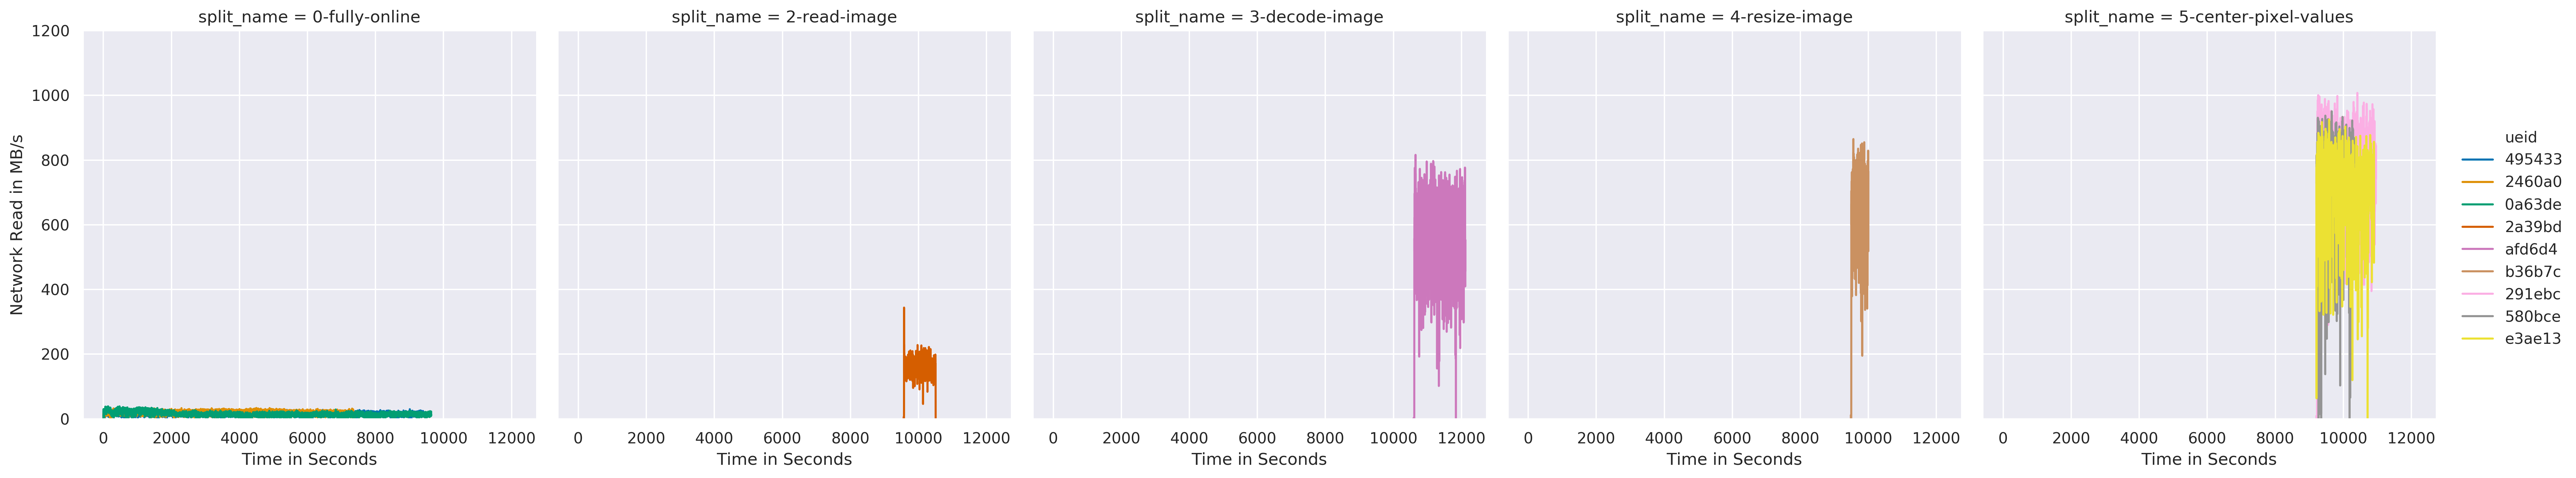

In [16]:
sns.set(palette=default_palette)

plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="ueid",
    col="split_name",
    kind="line",
    data=online_df,
    #ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

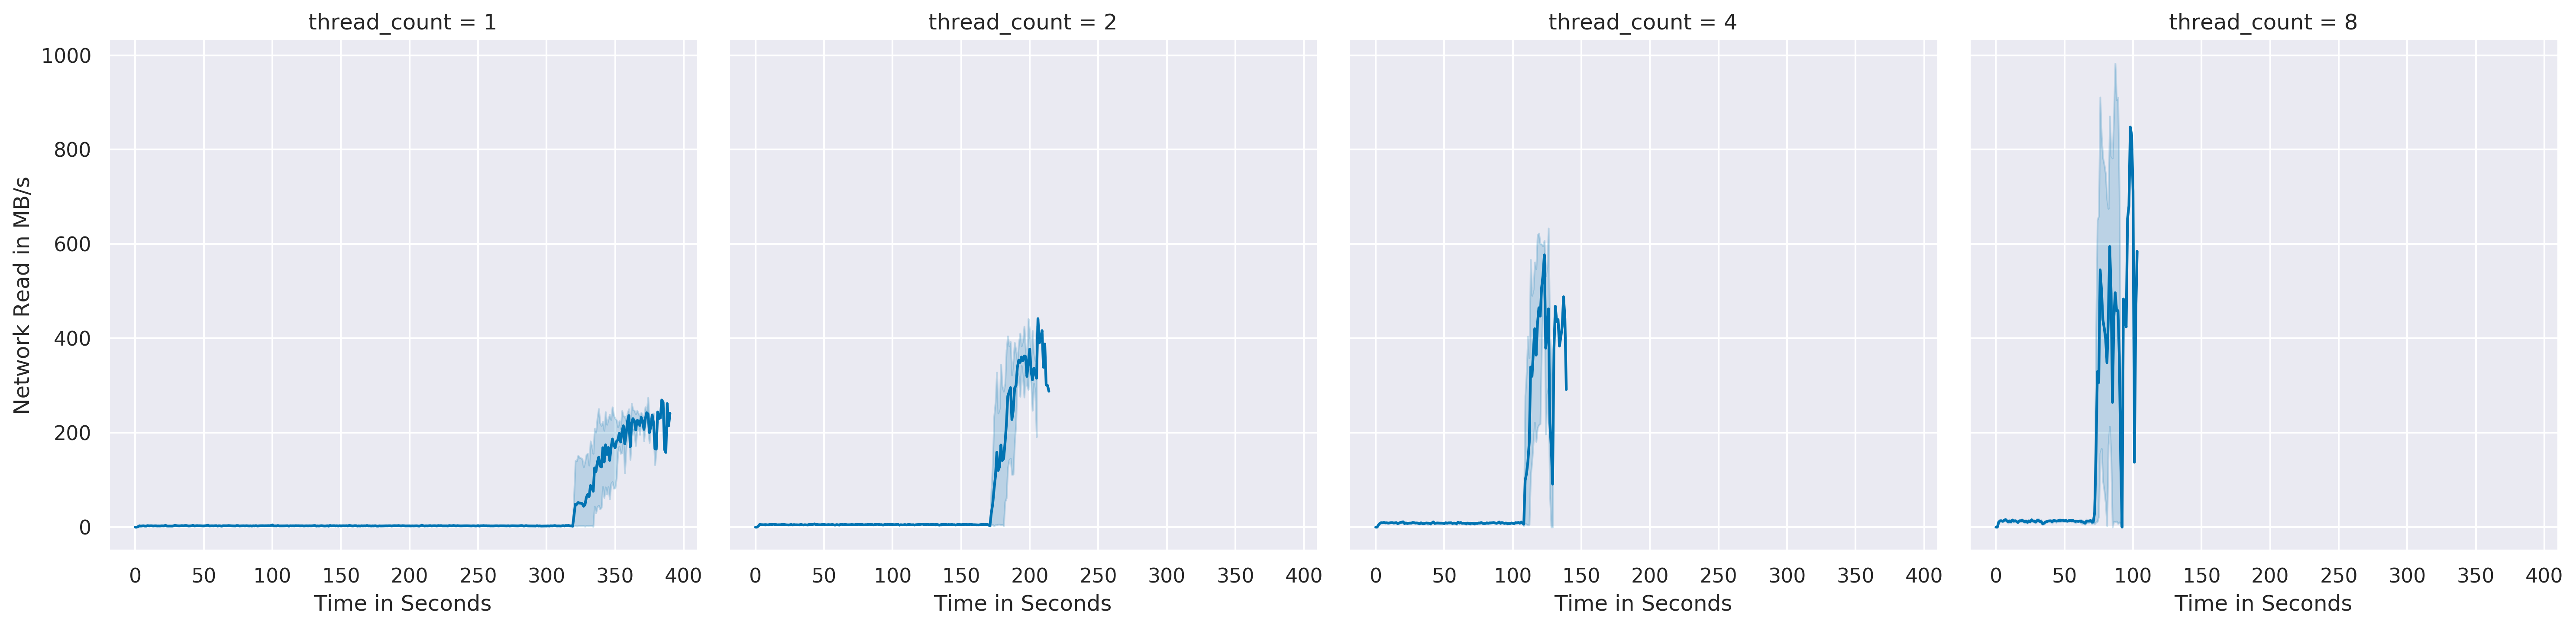

In [68]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={8000} and \
                                              run==0")
plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    col="thread_count",
    kind="line",
    data=cum_dstat_df_temp.query("split_name=='5-center-pixel-values'"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")

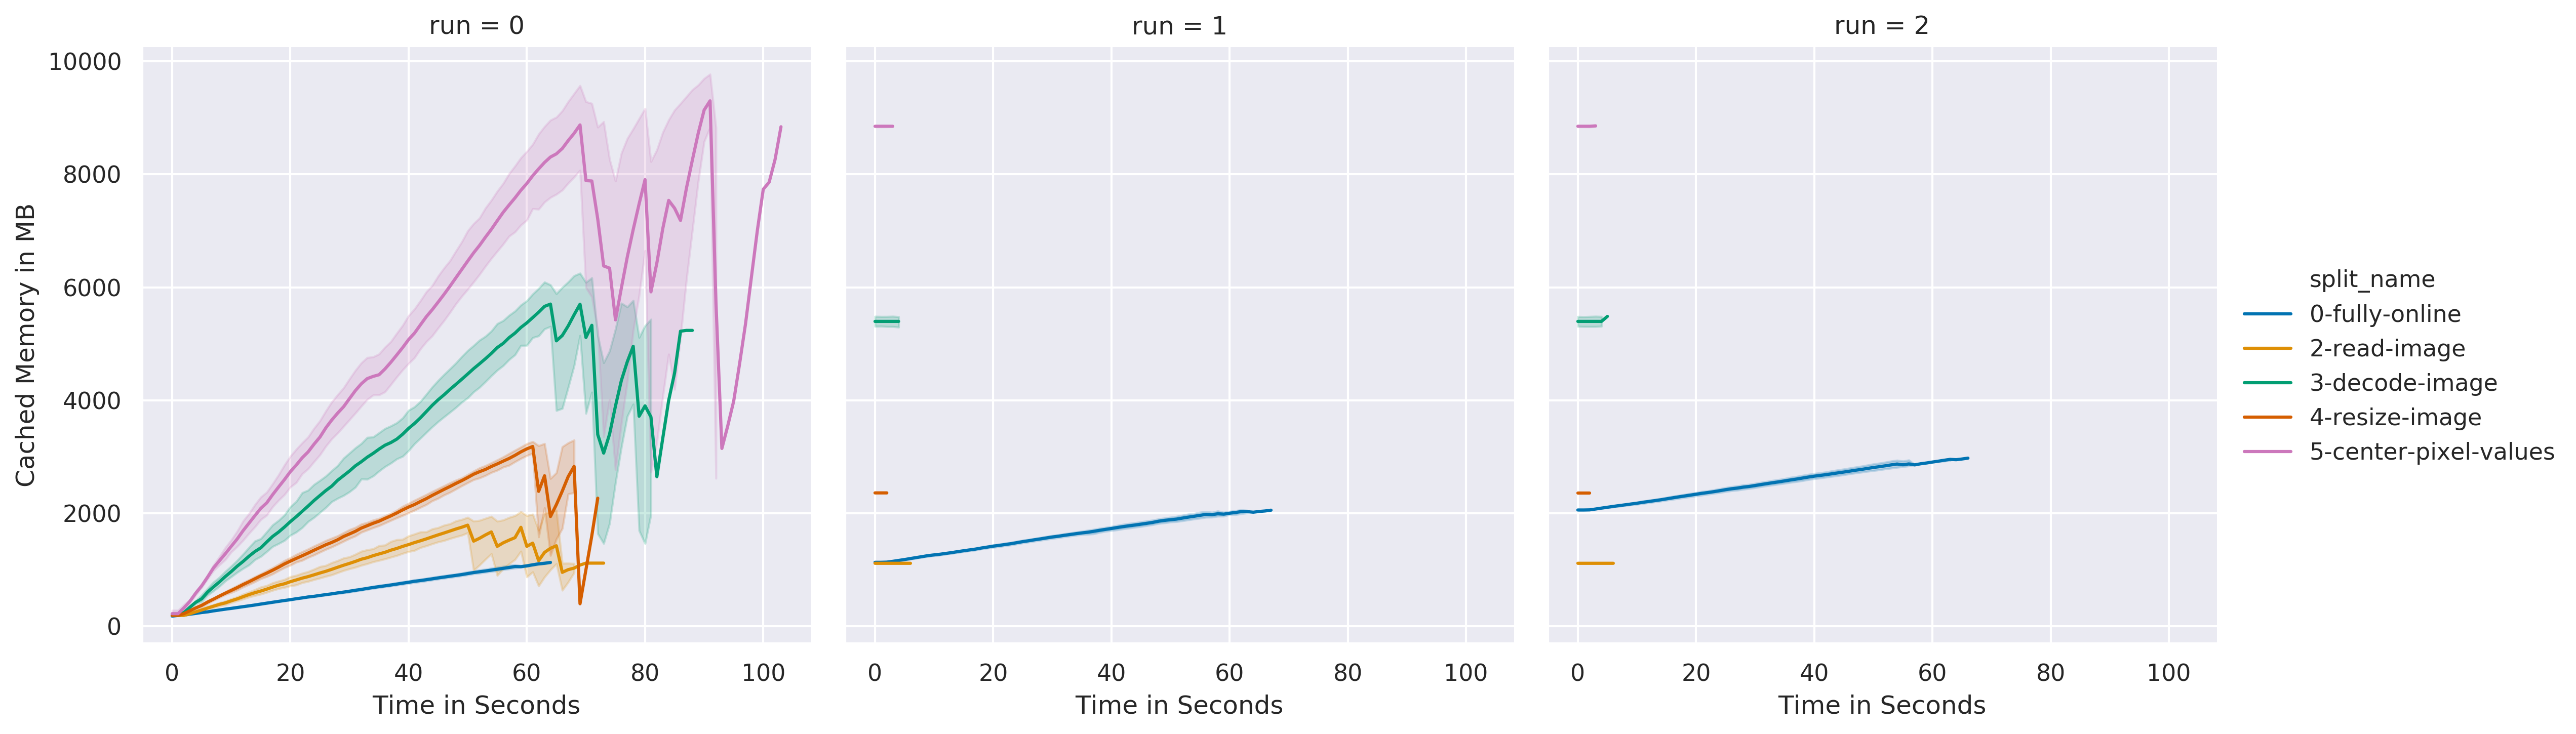

In [194]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={8000} and \
                                              thread_count==8")
plot = sns.relplot(
    x="rel_time_s",
    y="memory_cached_mb",
    hue="split_name",
    col="run",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Cached Memory in MB")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

/home/asa/.miniconda/envs/presto/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


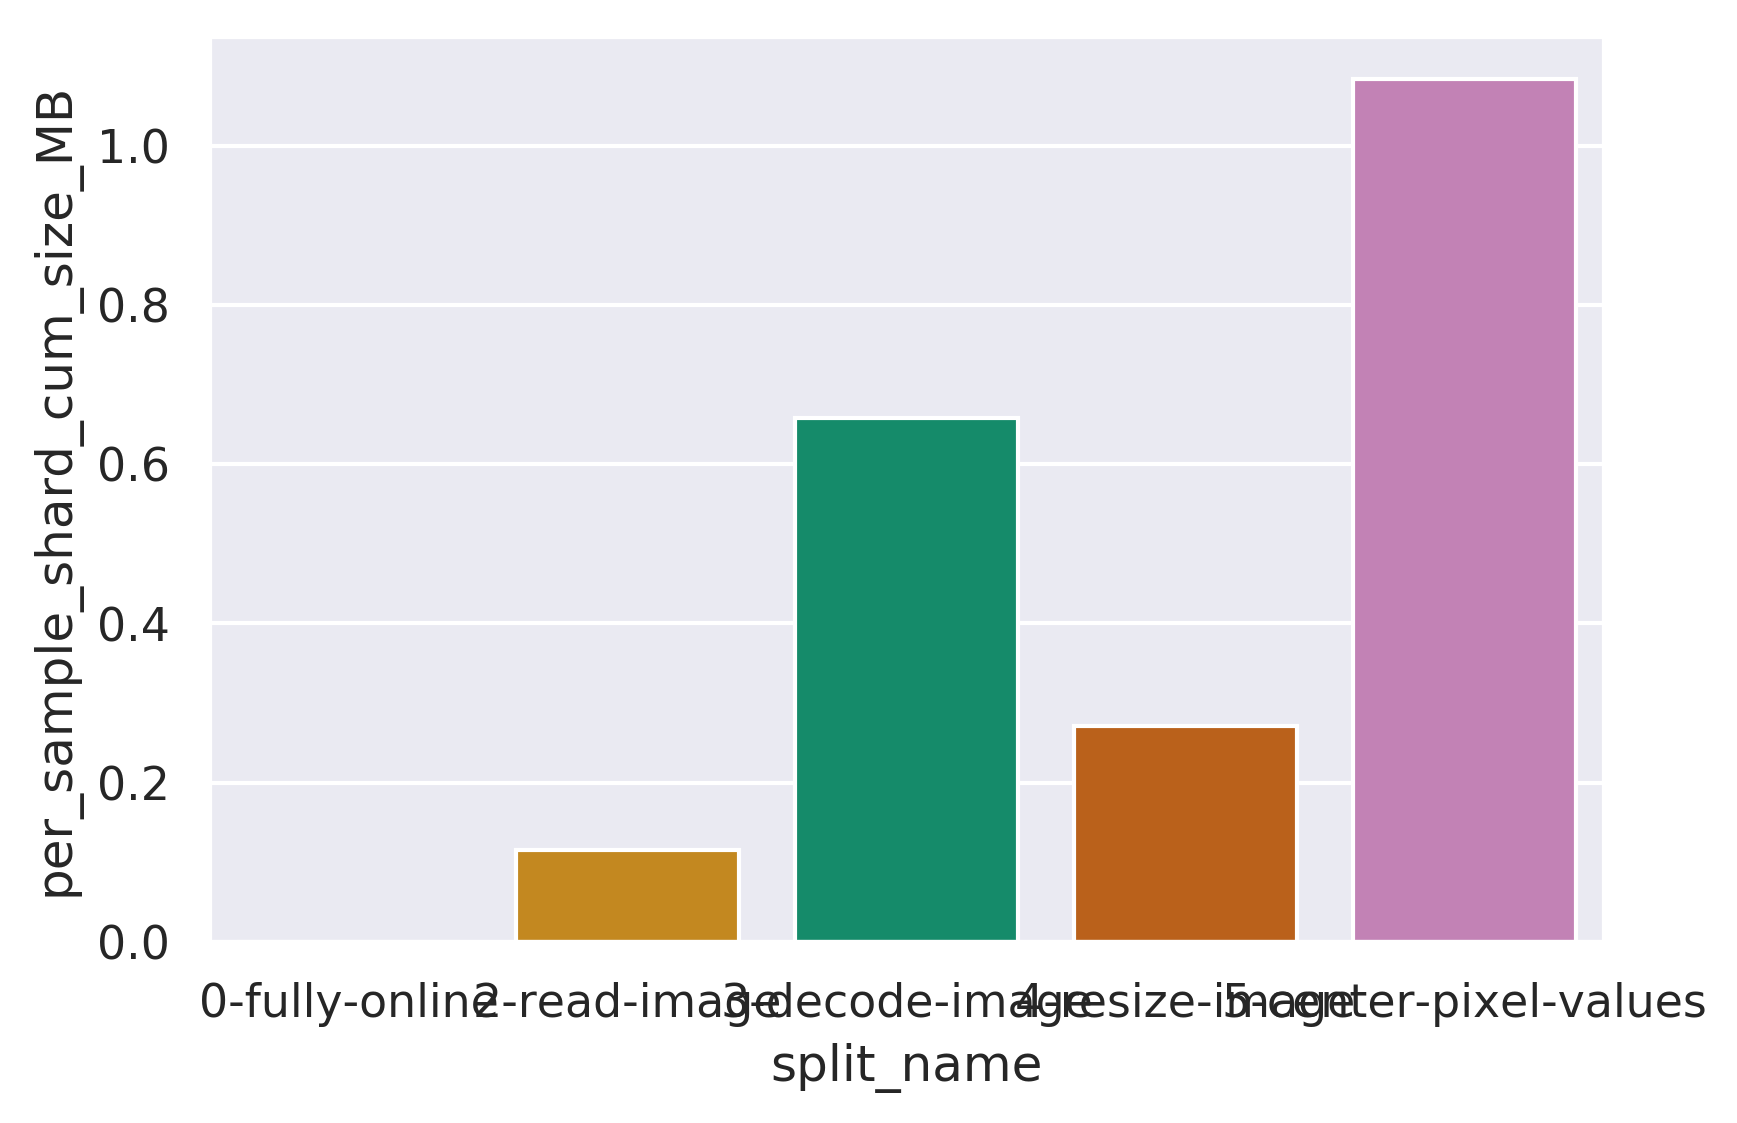

In [9]:
sns.set(palette=default_palette)
import sys

temp_df = cum_df.query(f"sample_count=={full_dataset_samplecount} and \
                                              thread_count==8 and \
                                              runs_count==0")

temp_df["per_sample_shard_cum_size_MB"] = temp_df["shard_cum_size_MB"] / full_dataset_samplecount


plot = sns.barplot(
    x="split_name",
    y="per_sample_shard_cum_size_MB",
    data=temp_df,
    ci=95
)